Filter jobs that succeeded

- "Calculating rate coefficient"

Failures in stderr.log

- "arc.exceptions.VectorsError: Could not calculate a dihedral angle for"
- "TypeError: can only concatenate str (not "int") to str" 

Exception in arc.log
- "Error: No conformer was found to be isomorphic with the 2D graph representation"
- "arc.exceptions.ReactionError", "is not atom balanced."


False Succeeded Jobs:

- "Warning: Could not determine a likely TS conformer for TS0", "All jobs for species TS0 successfully converged"

In [1]:
import re
import os
import pandas as pd

In [2]:
reaction_data = pd.DataFrame(columns=['reaction', 'server', 'converged', 'error', 'best_ts_method','branch'])

In [3]:
# Functions

def best_ts_method(data):
    for line in data:
        match = re.search(r'The method that generated the best TS guess and its output used for the optimization: (.*)', line)
        if match:
            return match.group(1)

    if not match:
        return None
    
def git_branch(data):
    """
    """
    for i, line in enumerate(data):
        if 'The current git' in line and 'ARC' in line:
            line = data[i + 3]
            match = re.search(r'the (.*) branch', line)
            if match:
                return match.group(1)
            else:
                return 'main'

In [4]:
main_paths = {'Zeus':["/home/calvin/Dropbox/PersonalFolders/Calvin/HAb_Converged"], 'Atlas': ["/home/calvin/Dropbox/PersonalFolders/Calvin/ATLAS_Converged", "/home/calvin/Dropbox/PersonalFolders/Calvin/ATLAS_Converged/NonRMG"]}


In [5]:
for server, item in main_paths.items():
    for main_path in item:
        for folders in os.listdir(main_path):
            processed = False
            if os.path.isdir(os.path.join(main_path, folders)) and folders != 'NonRMG':
                for files in os.listdir(os.path.join(main_path, folders)):
                    if files == "arc.log":
                        with open(os.path.join(main_path, folders, files), 'r') as f:
                            data = f.readlines()
                            processed = False
                            for line in reversed(data):
                                if 'Calculating rate coefficient' in line:
                                        reaction_data = pd.concat([reaction_data, pd.DataFrame([{
                                            'reaction': folders, 
                                            'server': server, 
                                            'converged': True, 
                                            'error': None,
                                            'best_ts_method': best_ts_method(data),
                                            'branch': git_branch(data)  # Temporary; will update later
                                        }])], ignore_index=True)
                                        processed = True
                                        break
                                elif "Warning: Could not determine a likely TS conformer for TS0" in line:
                                    reaction_data = pd.concat([reaction_data, pd.DataFrame([{
                                        'reaction': folders, 
                                        'server': server, 
                                        'converged': False, 
                                        'error': 'Could not determine likely TS conformer',
                                        'best_ts_method': None,
                                        'branch': git_branch(data)
                                    }])], ignore_index=True)
                                    processed = True
                                    break
                                elif 'did not converge, cannot compute a rate coefficient' in line:
                                        reaction_data = pd.concat([reaction_data, pd.DataFrame([{
                                            'reaction': folders, 
                                            'server': server, 
                                            'converged': True, 
                                            'error': 'Reactant or Product did not converge, but TS did',
                                            'best_ts_method': best_ts_method(data),
                                            'branch': git_branch(data)
                                        }])], ignore_index=True)
                                        processed = True
                                        break
                                elif 'TS TS0 did not pass all checks, not computing rate coefficient' in line:
                                        reaction_data = pd.concat([reaction_data, pd.DataFrame([{
                                            'reaction': folders,
                                            'server': server,
                                            'converged': True,
                                            'error': 'TS did not pass all checks',
                                            'best_ts_method': best_ts_method(data),
                                            'branch': git_branch(data)
                                        }])], ignore_index=True)
                                        processed = True
                                        break
                    elif files == "stderr.log" and not processed:
                        with open(os.path.join(main_path, folders, files), 'r') as f:
                            if 'OSError: [Errno 12] Cannot allocate memory':
                                reaction_data = pd.concat([reaction_data, pd.DataFrame([{
                                    'reaction': folders,
                                    'server': server,
                                    'converged': False, 
                                    'error': 'Memory Error',
                                    'branch': git_branch(data)
                                }])], ignore_index=True)
                            else:
                                reaction_data = pd.concat([reaction_data, pd.DataFrame([{
                                    'reaction': folders,
                                    'server': server,
                                    'converged': False, 
                                    'error': 'No relevant information found',
                                    'branch': git_branch(data)
                                }])], ignore_index=True)

In [6]:
# We need to check that `converged` column, when False, has an `error` and if nto filled, show whcih ones
reaction_data[reaction_data['converged'] == False & reaction_data['error'].isnull()]

,reaction,server,converged,error,best_ts_method,branch
2,rxn_1098,Zeus,False,Could not determine likely TS conformer,None,qchem
4,rxn_156,Zeus,False,Could not determine likely TS conformer,None,qchem
5,rxn_819,Zeus,False,Could not determine likely TS conformer,None,qchem
8,rxn_177,Zeus,False,Could not determine likely TS conformer,None,qchem
15,rxn_65,Zeus,False,Could not determine likely TS conformer,None,qchem
...,...,...,...,...,...,...
1947,rxn_3222,Atlas,False,Could not determine likely TS conformer,None,gauss_trsh_cleanup
1948,rxn_3166,Atlas,False,Could not determine likely TS conformer,None,gauss_trsh_cleanup
1950,rxn_3152,Atlas,False,Could not determine likely TS conformer,None,gauss_trsh_cleanup
1951,rxn_3170,Atlas,False,Could not determine likely TS conformer,None,gauss_trsh_cleanup


In [7]:
reaction_data

,reaction,server,converged,error,best_ts_method,branch
0,rxn_1366,Zeus,True,None,heuristics,qchem
1,rxn_1019,Zeus,True,None,heuristics,qchem
2,rxn_1098,Zeus,False,Could not determine likely TS conformer,None,qchem
3,rxn_1619,Zeus,True,None,heuristics,gaussian_unconverge_trsh
4,rxn_156,Zeus,False,Could not determine likely TS conformer,None,qchem
...,...,...,...,...,...,...
1951,rxn_3170,Atlas,False,Could not determine likely TS conformer,None,gauss_trsh_cleanup
1952,rxn_3330,Atlas,True,"Reactant or Product did not converge, but TS did",autotst,gauss_trsh_cleanup
1953,rxn_3211,Atlas,True,None,heuristics,gauss_trsh_cleanup
1954,rxn_3215,Atlas,True,None,heuristics,gauss_trsh_cleanup


In [8]:
reaction_data
# Count False in converged column
reaction_data['converged'].value_counts()
print(reaction_data['error'].value_counts())

error
Could not determine likely TS conformer             442
Reactant or Product did not converge, but TS did     80
TS did not pass all checks                           28
Memory Error                                          1
Name: count, dtype: int64


In [9]:
# Print which reactions have no releant info found
print(reaction_data[reaction_data['error'] == 'No relevant information found']['reaction'])

Series([], Name: reaction, dtype: object)


branch
qchem                          1117
gauss_trsh_cleanup              576
crest                            73
crest_nmd                        67
gaussian_unconverge_trsh         36
main                             33
heurist_impr                     21
gauss_conformer_comb             14
debug_statement                  12
zeus_run                          4
(HEAD detached at 7b8e561d)       3
Name: count, dtype: int64


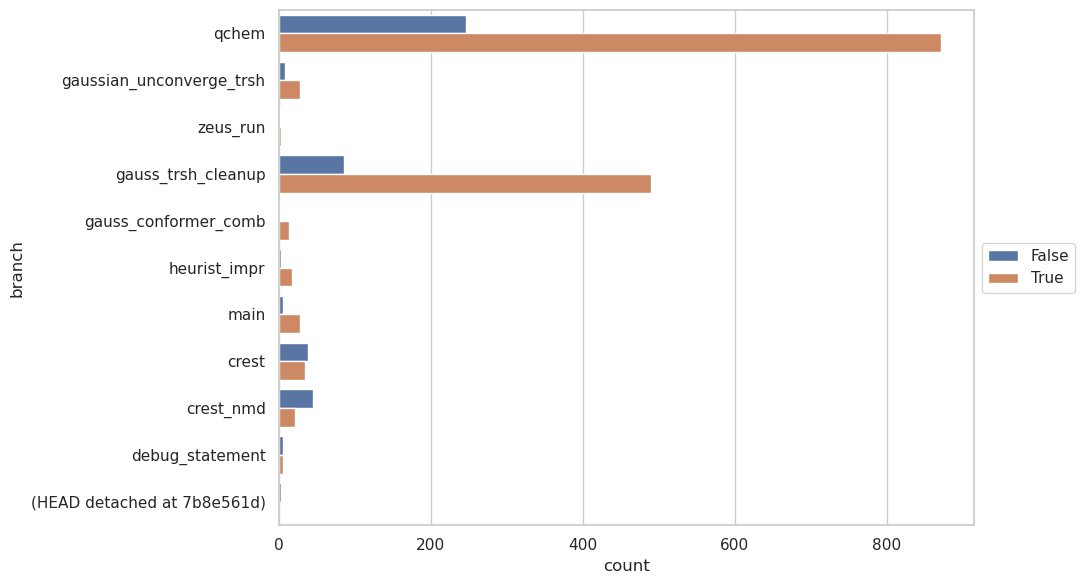

In [13]:
# Get unique branch names
reaction_data['branch'].unique()
print(reaction_data['branch'].value_counts())

# Get unique branch names and see the counts of how many failed against each branch
reaction_data.groupby(['branch', 'converged']).size()

# Let's plot the data
import matplotlib.pyplot as plt
import seaborn as sns


sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
# Plot branch fails and successes (horizontal orientation)
sns.countplot(data=reaction_data, y='branch', hue='converged', orient='h')
# Adjust spacing if necessary
plt.tight_layout()
# Put legend outside of plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()